# PROJECT OBJECTIVE: Design a DL based car identification model

## 1. Milestone 1: [ Score: 40 points] <br> Input: Context and Dataset <br> Process:
### Step 1: Import the data. [ 3 points ]

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, Activation
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Model
from tensorflow import expand_dims

from sklearn.metrics import classification_report
from glob import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_curve,accuracy_score,f1_score,precision_score,recall_score

#### Function to read all images

In [ ]:
# load the drive from google
from zipfile import ZipFile

from google.colab import drive
drive.mount('/content/drive')

# extract the images
images_path = "/content/drive/MyDrive/Project Files/Car+Images.zip"
with ZipFile(images_path,'r') as zip1:
  zip1.extractall()

# extract the images
annotations_path = "/content/drive/MyDrive/Project Files/Annotations.zip"
with ZipFile(annotations_path,'r') as zip2:
  zip2.extractall()

Mounted at /content/drive


In [ ]:
# method to load the images and its corresponding annotations
def loadImages(imagesPath):
    images = glob(imagesPath)
    img_list = []
    
    images_list_iter=iter(images)
    
    for i in range(len(images)):
        img=next(images_list_iter)
        images_dict={}
        #images_dict["car_orig_image"]=cv2.imread(img,cv2.IMREAD_GRAYSCALE) 
        images_dict["car_orig_image"]=cv2.imread(img) 
        images_dict["car_name"]=str(img.split('/')[-2])
        images_dict["car_image_name"]=str(img.split('/')[-1])   
        img_list.append(images_dict)
      
    return img_list

In [ ]:
## Reading all images in Train folder
train_images= loadImages('Car Images/Train Images/*/*.jpg')

In [ ]:
train_images[0]

{'car_orig_image': array([[[112, 116, 104],
         [108, 113, 104],
         [105, 114, 111],
         ...,
         [204, 199, 200],
         [247, 245, 245],
         [255, 254, 254]],
 
        [[108, 112, 100],
         [102, 110, 100],
         [104, 112, 111],
         ...,
         [204, 199, 200],
         [247, 245, 245],
         [255, 254, 254]],
 
        [[110, 116, 105],
         [105, 113, 103],
         [109, 117, 116],
         ...,
         [204, 199, 200],
         [247, 245, 245],
         [255, 254, 254]],
 
        ...,
 
        [[142, 145, 149],
         [138, 141, 145],
         [135, 138, 142],
         ...,
         [136, 136, 136],
         [231, 231, 231],
         [255, 255, 255]],
 
        [[145, 148, 152],
         [142, 145, 149],
         [138, 141, 145],
         ...,
         [134, 134, 134],
         [231, 231, 231],
         [255, 255, 255]],
 
        [[150, 153, 157],
         [146, 149, 153],
         [143, 146, 150],
         ...,
         [

In [ ]:
print("Number of images read in train set : {}".format(len(train_images)))

Number of images read in train set : 8144


In [ ]:
## Reading all images in Train folder
test_images= loadImages('Car Images/Test Images/*/*.jpg')

In [ ]:
test_images[0]

{'car_orig_image': array([[[ 1,  1,  1],
         [ 1,  1,  1],
         [ 1,  1,  1],
         ...,
         [ 1,  1,  1],
         [ 1,  1,  1],
         [ 1,  1,  1]],
 
        [[ 1,  1,  1],
         [ 1,  1,  1],
         [ 1,  1,  1],
         ...,
         [ 1,  1,  1],
         [ 1,  1,  1],
         [ 1,  1,  1]],
 
        [[ 1,  1,  1],
         [ 1,  1,  1],
         [ 1,  1,  1],
         ...,
         [ 1,  1,  1],
         [ 1,  1,  1],
         [ 1,  1,  1]],
 
        ...,
 
        [[16, 16, 16],
         [16, 16, 16],
         [16, 16, 16],
         ...,
         [16, 16, 16],
         [16, 16, 16],
         [16, 16, 16]],
 
        [[16, 16, 16],
         [16, 16, 16],
         [16, 16, 16],
         ...,
         [18, 18, 18],
         [17, 17, 17],
         [17, 17, 17]],
 
        [[16, 16, 16],
         [16, 16, 16],
         [16, 16, 16],
         ...,
         [18, 18, 18],
         [17, 17, 17],
         [17, 17, 17]]], dtype=uint8),
 'car_name': 'Audi R8 Co

In [ ]:
print("Number of images read in test set : {}".format(len(test_images)))

Number of images read in test set : 8041


### Step 2: Map training and testing images to its classes. [ 6 points ]
### Step 3: Map training and testing images to its annotations. [ 6 points ]

#### Function to read the Annotations file and map the details to respective image.
Note: Assigning classes and anaotations in separate steps will result in memory and compute waste. So the below function addresses both the assignments in one go.

In [ ]:
def loadAnnot_map(annotPath,images_list):
    images_list_iter=iter(images_list)

    annots_df=pd.read_csv(annotPath)
    annots_df.rename(columns={'Image Name':'car_image_name', 'Bounding Box coordinates':'x1', 'Unnamed: 2':'y1','Unnamed: 3': 'x2', 'Unnamed: 4': 'y2', 'Image class': 'image_class'},inplace=True)
    annots_df["bounding_box"]=list(annots_df[['x1', 'y1', 'x2', 'y2']].to_records(index=False))  
    annots_dict = dict([(i,[x,y]) for i, x,y in zip(annots_df.car_image_name, annots_df.image_class,annots_df.bounding_box)])
    imglist_upd=[]
    for i in range(len(images_list)):
        img_dict=next(images_list_iter)
        car_img_nm=img_dict["car_image_name"]  
        img_dict["car_image_class"]=annots_dict[car_img_nm][0]
        img_dict["bounding_box"]=annots_dict[car_img_nm][1]
        imglist_upd.append(img_dict)
      
    return imglist_upd

In [ ]:
## Reading annotations for train set and mapping to train images
train_images_upd= loadAnnot_map('Annotations/Train Annotations.csv',train_images)

In [ ]:
## Sample record
train_images_upd[0]

{'car_orig_image': array([[[112, 116, 104],
         [108, 113, 104],
         [105, 114, 111],
         ...,
         [204, 199, 200],
         [247, 245, 245],
         [255, 254, 254]],
 
        [[108, 112, 100],
         [102, 110, 100],
         [104, 112, 111],
         ...,
         [204, 199, 200],
         [247, 245, 245],
         [255, 254, 254]],
 
        [[110, 116, 105],
         [105, 113, 103],
         [109, 117, 116],
         ...,
         [204, 199, 200],
         [247, 245, 245],
         [255, 254, 254]],
 
        ...,
 
        [[142, 145, 149],
         [138, 141, 145],
         [135, 138, 142],
         ...,
         [136, 136, 136],
         [231, 231, 231],
         [255, 255, 255]],
 
        [[145, 148, 152],
         [142, 145, 149],
         [138, 141, 145],
         ...,
         [134, 134, 134],
         [231, 231, 231],
         [255, 255, 255]],
 
        [[150, 153, 157],
         [146, 149, 153],
         [143, 146, 150],
         ...,
         [

In [ ]:
print("Number of images in updated train image list : {}".format(len(train_images_upd)))

Number of images in updated train image list : 8144


In [ ]:
del train_images

In [ ]:
## Let us explore the train set 
train_cars=pd.DataFrame([{'car_name': x['car_name'], 'image_size': x['car_orig_image'].shape, 'car_image_class':x['car_image_class']} for x in train_images_upd])

In [ ]:
cars_uniq= train_cars[['car_image_class','car_name']]
cars_uniq=cars_uniq.drop_duplicates()
cars_dict=dict(cars_uniq.values)
cars_dict

{15: 'Audi R8 Coupe 2012',
 19: 'Audi TT Hatchback 2011',
 186: 'Toyota Sequoia SUV 2012',
 119: 'GMC Savana Van 2012',
 25: 'Audi TT RS Coupe 2012',
 32: 'BMW X5 SUV 2007',
 107: 'Ford Mustang Convertible 2007',
 106: 'Ford F-450 Super Duty Crew Cab 2012',
 188: 'Toyota Corolla Sedan 2012',
 94: 'Dodge Durango SUV 2012',
 89: 'Dodge Journey SUV 2012',
 51: 'Cadillac CTS-V Sedan 2012',
 152: 'Lamborghini Gallardo LP 570-4 Superleggera 2012',
 104: 'Ferrari 458 Italia Coupe 2012',
 6: 'Acura Integra Type R 2001',
 91: 'Dodge Dakota Club Cab 2007',
 24: 'Audi S4 Sedan 2007',
 52: 'Cadillac SRX SUV 2012',
 125: 'HUMMER H2 SUT Crew Cab 2009',
 49: 'Buick Verano Sedan 2012',
 75: 'Chevrolet Silverado 1500 Regular Cab 2012',
 138: 'Hyundai Sonata Sedan 2012',
 187: 'Toyota Camry Sedan 2012',
 13: 'Audi A5 Coupe 2012',
 142: 'Infiniti QX56 SUV 2011',
 29: 'BMW 3 Series Sedan 2012',
 126: 'Honda Odyssey Minivan 2012',
 150: 'Lamborghini Reventon Coupe 2008',
 124: 'HUMMER H3T Crew Cab 2010',
 

In [ ]:
train_cars_cnt=train_cars['car_name'].value_counts(sort=True)
train_cars_cnt_df = pd.DataFrame(train_cars_cnt)
train_cars_cnt_df = train_cars_cnt_df.reset_index()
train_cars_cnt_df.columns = ['car_names', 'counts']

In [ ]:
train_cars_cnt_df.sort_values(by=['counts'],ascending=False).head()

,car_names,counts
0,GMC Savana Van 2012,68
1,Chrysler 300 SRT-8 2010,49
2,Mitsubishi Lancer Sedan 2012,48
3,Mercedes-Benz 300-Class Convertible 1993,48
4,Jaguar XK XKR 2012,47


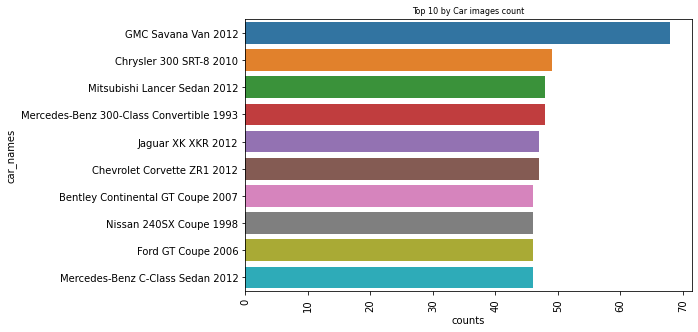

In [ ]:
## Plotting by car images count - Top 10
plt.figure(figsize=(8,5))
train_cars_cnt_df.sort_values(by=['counts'],ascending=False)
sns.barplot(data=train_cars_cnt_df.head(10), x='counts',y='car_names')
plt.xticks(rotation=90)
plt.title("Top 10 by Car images count",size=8)
plt.show()

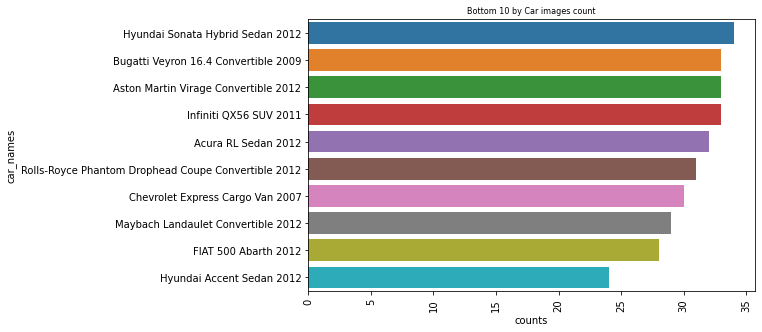

In [ ]:
## Plotting by car images count - Bottom 10
plt.figure(figsize=(8,5))
train_cars_cnt_df.sort_values(by=['counts'],ascending=False)
sns.barplot(data=train_cars_cnt_df.tail(10), x='counts',y='car_names')
plt.xticks(rotation=90)
plt.title("Bottom 10 by Car images count",size=8)
plt.show()

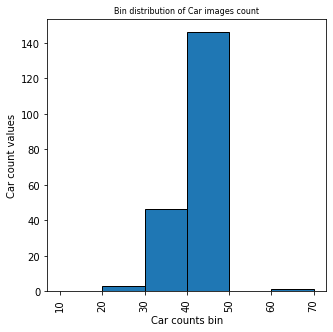

In [ ]:
## Plotting car images count for each bin 
plt.figure(figsize=(5,5))
train_cars_cnt_df.sort_values(by=['counts'],ascending=True)
bins=[10,20,30,40,50,60,70]
plt.hist(train_cars_cnt_df['counts'].values, bins=bins, edgecolor="k")
plt.xticks(rotation=90)
plt.xlabel('Car counts bin')
plt.ylabel('Car count values')
plt.title("Bin distribution of Car images count",size=8)
plt.show()

#### As we see above, for around 140 cars we have 40-50 images, for around 50 cars we have 30-40 images. For few cars we have very less numbers of images i.e 20-30. For just 1 car we have high number of images i.e 60-70

In [ ]:
## Showing some samples 
train_cars.sample(15)

,car_name,image_size,car_image_class
5261,Honda Odyssey Minivan 2012,"(392, 588, 3)",126
7856,Toyota Sequoia SUV 2012,"(450, 600, 3)",186
5370,Hyundai Accent Sedan 2012,"(348, 607, 3)",136
848,Audi S6 Sedan 2011,"(1200, 1600, 3)",20
5632,Hyundai Sonata Hybrid Sedan 2012,"(281, 600, 3)",134
5859,Infiniti QX56 SUV 2011,"(353, 607, 3)",142
7859,Toyota Sequoia SUV 2012,"(235, 500, 3)",186
2398,Chevrolet Corvette ZR1 2012,"(373, 592, 3)",56
2132,Cadillac SRX SUV 2012,"(480, 640, 3)",52
4375,Ford Edge SUV 2012,"(525, 700, 3)",110


#### From the above samples, it is evident that sizes of the images are way different from each other. To use in CNN model the images need to be resized to common size and normalized. 

In [ ]:
del train_cars,train_cars_cnt, train_cars_cnt_df

In [ ]:
## Reading annotations for train set and mapping to train images
test_images_upd= loadAnnot_map('Annotations/Test Annotation.csv',test_images)

In [ ]:
## Sample 
test_images_upd[0]

{'car_orig_image': array([[[ 1,  1,  1],
         [ 1,  1,  1],
         [ 1,  1,  1],
         ...,
         [ 1,  1,  1],
         [ 1,  1,  1],
         [ 1,  1,  1]],
 
        [[ 1,  1,  1],
         [ 1,  1,  1],
         [ 1,  1,  1],
         ...,
         [ 1,  1,  1],
         [ 1,  1,  1],
         [ 1,  1,  1]],
 
        [[ 1,  1,  1],
         [ 1,  1,  1],
         [ 1,  1,  1],
         ...,
         [ 1,  1,  1],
         [ 1,  1,  1],
         [ 1,  1,  1]],
 
        ...,
 
        [[16, 16, 16],
         [16, 16, 16],
         [16, 16, 16],
         ...,
         [16, 16, 16],
         [16, 16, 16],
         [16, 16, 16]],
 
        [[16, 16, 16],
         [16, 16, 16],
         [16, 16, 16],
         ...,
         [18, 18, 18],
         [17, 17, 17],
         [17, 17, 17]],
 
        [[16, 16, 16],
         [16, 16, 16],
         [16, 16, 16],
         ...,
         [18, 18, 18],
         [17, 17, 17],
         [17, 17, 17]]], dtype=uint8),
 'car_name': 'Audi R8 Co

In [ ]:
print("Number of images in updated test image list : {}".format(len(test_images_upd)))

Number of images in updated test image list : 8041


In [ ]:
## Let us explore the test set 
test_cars=pd.DataFrame([{'car_name': x['car_name'], 'image_size': x['car_orig_image'].shape, 'car_image_class':x['car_image_class']} for x in test_images_upd])

In [ ]:
test_cars_cnt=test_cars['car_name'].value_counts(sort=True)
test_cars_cnt_df = pd.DataFrame(test_cars_cnt)
test_cars_cnt_df = test_cars_cnt_df.reset_index()
test_cars_cnt_df.columns = ['car_names', 'counts']

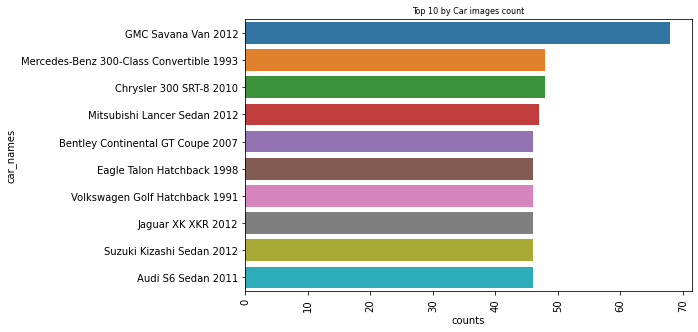

In [ ]:
## Plotting by car images count - Top 10
from matplotlib import pyplot as plt
plt.figure(figsize=(8,5))
test_cars_cnt_df.sort_values(by=['counts'],ascending=False)
sns.barplot(data=test_cars_cnt_df.head(10), x='counts',y='car_names')
plt.xticks(rotation=90)
plt.title("Top 10 by Car images count",size=8)
plt.show()

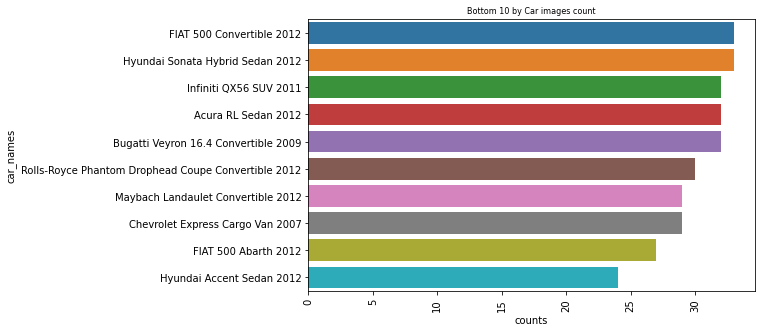

In [ ]:
## Plotting by car images count - Bottom 10
plt.figure(figsize=(8,5))
test_cars_cnt_df.sort_values(by=['counts'],ascending=False)
sns.barplot(data=test_cars_cnt_df.tail(10), x='counts',y='car_names')
plt.xticks(rotation=90)
plt.title("Bottom 10 by Car images count",size=8)
plt.show()

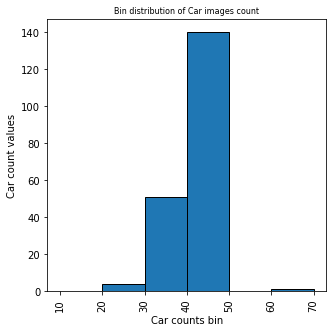

In [ ]:
## Plotting car images count for each bin 
plt.figure(figsize=(5,5))
test_cars_cnt_df.sort_values(by=['counts'],ascending=True)
bins=[10,20,30,40,50,60,70]
plt.hist(test_cars_cnt_df['counts'].values, bins=bins, edgecolor="k")
plt.xticks(rotation=90)
plt.xlabel('Car counts bin')
plt.ylabel('Car count values')
plt.title("Bin distribution of Car images count",size=8)
plt.show()

#### As we see above, for around 140 cars we have 40-50 images, for around 50 cars we have 30-40 images. For few cars we have very less numbers of images i.e 20-30. For just 1 car we have high number of images i.e 60-70
#### This behaviour is very similar to train set.

In [ ]:
test_cars.sample(15)

,car_name,image_size,car_image_class
5905,Jeep Compass SUV 2012,"(1067, 1600, 3)",149
815,Audi S6 Sedan 2011,"(250, 470, 3)",20
4321,Ford Edge SUV 2012,"(720, 960, 3)",110
6765,MINI Cooper Roadster Convertible 2012,"(512, 640, 3)",157
7504,Suzuki SX4 Hatchback 2012,"(492, 786, 3)",183
3432,Dodge Caravan Minivan 1997,"(375, 500, 3)",85
3985,Eagle Talon Hatchback 1998,"(300, 400, 3)",98
5080,Honda Accord Coupe 2012,"(768, 1024, 3)",128
2340,Chevrolet Corvette Ron Fellows Edition Z06 2007,"(69, 112, 3)",57
2887,Chevrolet Sonic Sedan 2012,"(450, 663, 3)",63


#### From the above samples, it is evident that sizes of the images are way different from each other. To use in CNN model the images need to be resized to common size and normalized. 

In [ ]:
del test_images, test_cars, test_cars_cnt, test_cars_cnt_df

### Step 4: Display images with bounding box. [ 5 points ]

In [ ]:
from matplotlib import pyplot as plt
def show_images(images_list,n):
    rand = np.random.randint(0, len(images_list), n) # Generating n random numbers from total number of images
    print("Showing images with index in : {}".format(rand))
    plt.figure(figsize=(10, 20))
    for cnt,j in enumerate(rand):
        plt.subplot(n, 2, (cnt*2)+1)
        plt.title(images_list[j]['car_name'])
        plt.imshow(images_list[j]['car_orig_image'])
        plt.subplot(n, 2, (cnt*2)+2)
        temp_image=images_list[j]['car_orig_image'].copy()

        gray = cv2.cvtColor(temp_image, cv2.COLOR_BGR2GRAY)
        (x1, y1, x2, y2)=images_list[j]['bounding_box']
        cv2.rectangle(temp_image, (x1,y1), (x2,y2), (255,0,0), 4)  
        plt.title(images_list[j]['car_name'])
        plt.imshow(temp_image)

Showing images with index in : [5700 4181 7966 3086 3899]


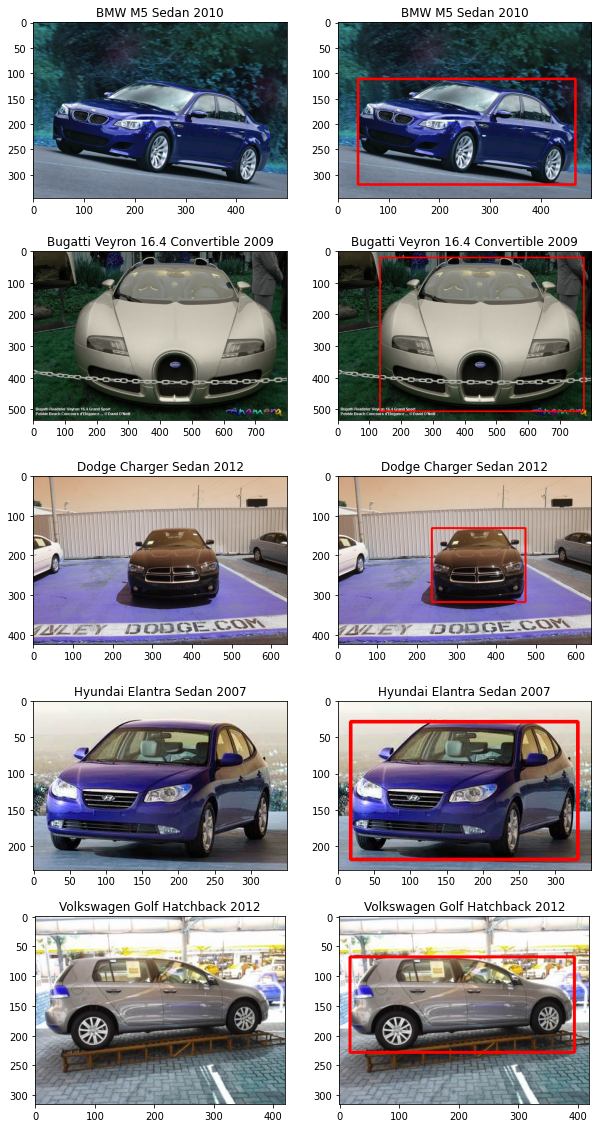

In [ ]:
show_images(train_images_upd,5)

Showing images with index in : [1132 3083 4255 5510 1329]


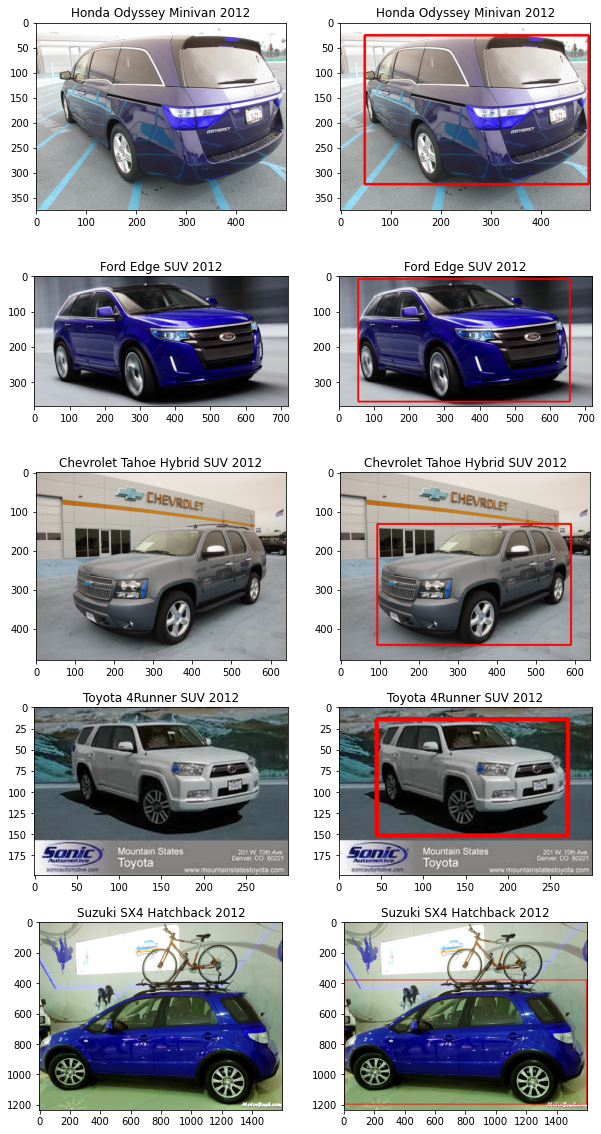

In [ ]:
show_images(test_images_upd,5)

In [ ]:
from matplotlib import pyplot as plt
def show_resized_images(images_list,n):
    rand = np.random.randint(0, len(images_list), n) # Generating n random numbers from total number of images
    print("Showing images with index in : {}".format(rand))
    plt.figure(figsize=(10, 20))
    for cnt,j in enumerate(rand):
        plt.subplot(n, 2, (cnt*2)+1)
        plt.title(images_list[j]['car_name'])
        img_orig=images_list[j]['car_orig_image']
        img_upd = cv2.resize(images_list[j]['car_orig_image'], dsize = (224,224))
        plt.imshow(img_upd)
        plt.subplot(n, 2, (cnt*2)+2)
        temp_image=img_upd.copy()
        (img_orig_h, img_orig_w, c)=img_orig.shape
        gray = cv2.cvtColor(temp_image, cv2.COLOR_BGR2GRAY)
        (x1, y1, x2, y2)=images_list[j]['bounding_box']
        x1_=int((x1/img_orig_w)*224)
        x2_=int((x2/img_orig_w)*224)
        y1_=int((y1/img_orig_h)*224)
        y2_=int((y2/img_orig_h)*224)
        cv2.rectangle(temp_image, (x1_,y1_), (x2_,y2_), (255,0,0), 4)  
        plt.title(images_list[j]['car_name'])
        plt.imshow(temp_image)

Showing images with index in : [1882 2930  407 3542 5271]


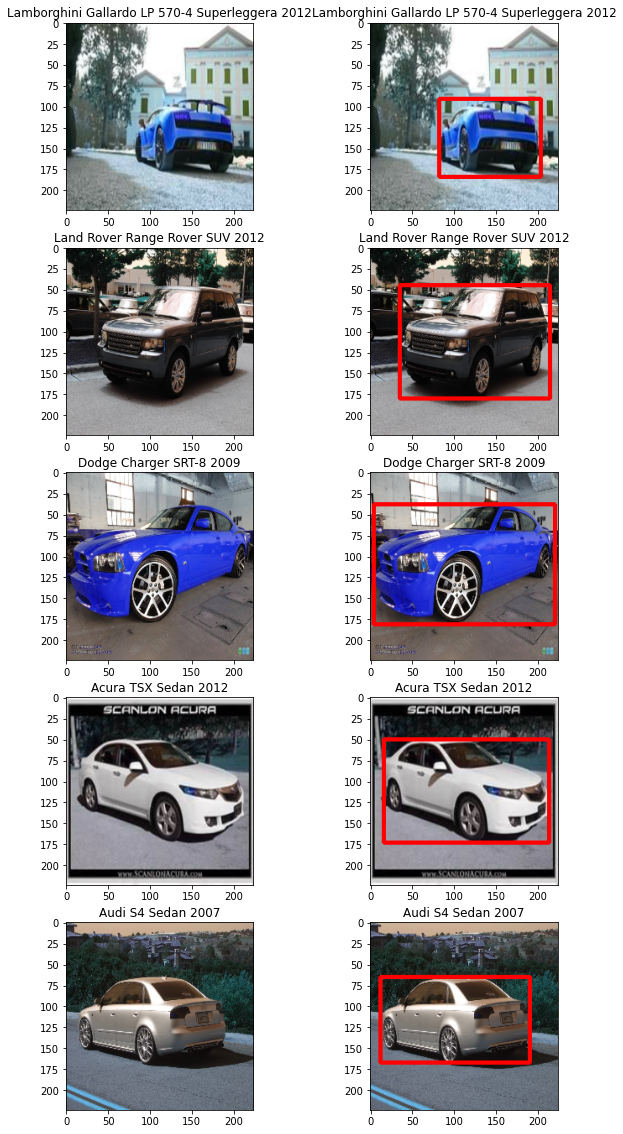

In [ ]:
show_resized_images(train_images_upd,5)

Showing images with index in : [7363 4925 3136 2300 1074]


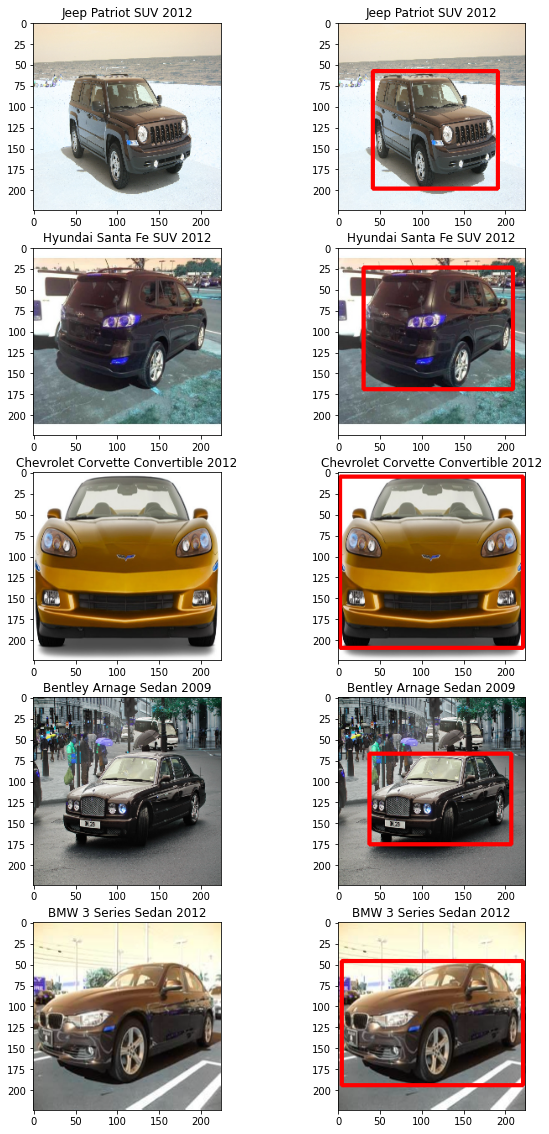

In [ ]:
show_resized_images(test_images_upd,5)

### Step 5: Design, train and test basic CNN models to classify the car. [ 10 points ]

**Normalize the images**

In [ ]:
def normalize_images(images_list):
    img_norm=[]
    images_list_iter=iter(images_list)
    
    for i in range(len(images_list)):
        
        x=next(images_list_iter)
        # Normalising pixel values
        img=x['car_orig_image']
        img_upd = (img / 255.).astype(np.float32)

        #resizing to (128,128)
        img_upd = cv2.resize(img_upd, dsize = (128,128))
        img_norm.append(img_upd)
        del img,img_upd
        
    img_arr=np.array(img_norm)
    return img_arr

In [ ]:
X_train=normalize_images(train_images_upd)

In [ ]:
X_train.shape

(8144, 128, 128, 3)

In [ ]:
X_train[0]

array([[[0.40693146, 0.43825516, 0.42406845],
        [0.56258523, 0.6316143 , 0.7239244 ],
        [0.56564176, 0.6475964 , 0.7225045 ],
        ...,
        [0.8117647 , 0.7921569 , 0.79607844],
        [0.8189032 , 0.79929537, 0.80321693],
        [0.8461091 , 0.8297182 , 0.8325674 ]],

       [[0.44258076, 0.4790068 , 0.47279078],
        [0.5042842 , 0.5789216 , 0.6645427 ],
        [0.5265848 , 0.60241747, 0.67387193],
        ...,
        [0.8117647 , 0.7921569 , 0.79607844],
        [0.8189032 , 0.79929537, 0.80321693],
        [0.8461091 , 0.8297182 , 0.8325674 ]],

       [[0.5176861 , 0.5562891 , 0.57163835],
        [0.5475268 , 0.62560725, 0.70842814],
        [0.5407605 , 0.6103925 , 0.6789716 ],
        ...,
        [0.8117647 , 0.7921569 , 0.79607844],
        [0.8189032 , 0.79929537, 0.80321693],
        [0.8461091 , 0.8297182 , 0.8325674 ]],

       ...,

       [[0.52763486, 0.53939956, 0.55508584],
        [0.53011644, 0.54188114, 0.5575674 ],
        [0.5312129 , 0

In [ ]:
y_train=pd.DataFrame([x['car_image_class'] for x in train_images_upd])

In [ ]:
y_train.shape

(8144, 1)

In [ ]:
y_train

,0
0,15
1,15
2,15
3,15
4,15
...,...
8139,177
8140,177
8141,177
8142,177


In [ ]:
del train_images_upd

In [ ]:
del test_images

In [ ]:
X_test=normalize_images(test_images_upd)

In [ ]:
X_test.shape

(8041, 128, 128, 3)

In [ ]:
X_test[0]

array([[[0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        ...,
        [0.01488971, 0.01488971, 0.01488971],
        [0.01624876, 0.01624876, 0.01624876],
        [0.00925245, 0.00925245, 0.00925245]],

       [[0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        ...,
        [0.00943005, 0.00943005, 0.00943005],
        [0.01568628, 0.01568628, 0.01568628],
        [0.01176471, 0.01176471, 0.01176471]],

       [[0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        ...,
        [0.01176471, 0.01176471, 0.01176471],
        [0.02291667, 0.02291667, 0.02291667],
        [0.01568628, 0.01568628, 0.01568628]],

       ...,

       [[0.07129289, 0.07129289, 0.07129289],
        [0.08125   , 0.08125   , 0.08125   ],
        [0.12062892, 0

In [ ]:
y_test=pd.DataFrame([x['car_image_class'] for x in test_images_upd])

In [ ]:
y_test.shape

(8041, 1)

In [ ]:
y_test

,0
0,15
1,15
2,15
3,15
4,15
...,...
8036,177
8037,177
8038,177
8039,177


In [ ]:
del test_images_upd

In [ ]:
print("Shape of X_train : {}".format(X_train.shape))
print("Shape of y_train : {}".format(y_train.shape))
print("Shape of X_test : {}".format(X_test.shape))
print("Shape of y_test : {}".format(y_test.shape))

Shape of X_train : (8144, 128, 128, 3)
Shape of y_train : (8144, 1)
Shape of X_test : (8041, 128, 128, 3)
Shape of y_test : (8041, 1)


In [ ]:
# encode labels for y_train
from keras.utils import np_utils
le = LabelEncoder()
le.fit(y_train[0])
encoded_labels_train = le.transform(y_train[0])
y_train_encoded = np_utils.to_categorical(encoded_labels_train)

In [ ]:
encoded_labels_test = le.transform(y_test[0])
y_test_encoded = np_utils.to_categorical(encoded_labels_test)

In [ ]:
class_dict={l: i for (i, l) in enumerate(le.classes_)}

In [ ]:
y_train_encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
y_test_encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

**Basic CNN classifier model**

In [ ]:
# Initialising the CNN classifier
cnn_classifier = Sequential()

# Add a Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
cnn_classifier.add(Conv2D(32, (3, 3), input_shape = (128,128,3), activation = 'relu', padding = 'same'))

# Add a Max Pooling layer of size 2X2
cnn_classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Add another Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
cnn_classifier.add(Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))

# Adding another pooling layer
cnn_classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding dropout with probability 0.4
cnn_classifier.add(Dropout(0.4))

# Flattening the layer before fully connected layers
cnn_classifier.add(Flatten())

# Adding a fully connected layer with 256 neurons
cnn_classifier.add(Dense(units = 512, activation = 'relu'))

# Adding dropout with probability 0.4
cnn_classifier.add(Dropout(0.4))

# Adding a fully connected layer with 256 neurons
cnn_classifier.add(Dense(units = 256, activation = 'relu'))

# The final output layer with 17 neuron to predict the categorical classifcation
cnn_classifier.add(Dense(units = 196, activation = 'softmax'))


In [ ]:
opt = Adam()
cnn_classifier.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
base_cnn_model = cnn_classifier.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), epochs=30, batch_size=64, verbose=1)

Epoch 1/30
128/128 [==============================] - 12s 68ms/step - loss: 5.3157 - accuracy: 0.0049 - val_loss: 5.2751 - val_accuracy: 0.0103
Epoch 2/30
128/128 [==============================] - 7s 53ms/step - loss: 5.2203 - accuracy: 0.0112 - val_loss: 5.1581 - val_accuracy: 0.0147
Epoch 3/30
128/128 [==============================] - 7s 54ms/step - loss: 5.0838 - accuracy: 0.0193 - val_loss: 5.0591 - val_accuracy: 0.0160
Epoch 4/30
128/128 [==============================] - 7s 53ms/step - loss: 4.6949 - accuracy: 0.0580 - val_loss: 5.0258 - val_accuracy: 0.0287
Epoch 5/30
128/128 [==============================] - 7s 53ms/step - loss: 3.7525 - accuracy: 0.1902 - val_loss: 5.2733 - val_accuracy: 0.0323
Epoch 6/30
128/128 [==============================] - 7s 53ms/step - loss: 2.4539 - accuracy: 0.4357 - val_loss: 5.9870 - val_accuracy: 0.0317
Epoch 7/30
128/128 [==============================] - 7s 53ms/step - loss: 1.3999 - accuracy: 0.6600 - val_loss: 6.6927 - val_accuracy: 0.032

In [ ]:
base_model_result = cnn_classifier.evaluate(X_test, y_test_encoded)

252/252 [==============================] - 2s 9ms/step - loss: 8.8515 - accuracy: 0.0332


In [ ]:
print('Test loss: ', base_model_result[0])
print('Test accuracy: ', base_model_result[1])

Test loss:  8.851463317871094
Test accuracy:  0.0332048237323761


### Insights:
The model has produced 97.36% accuracy in train set and just 3.32% accuracy in test set.

The model has overfitted in training set, giving very low accuracy in test set.This model needs further hyperparameter tuning. 
We may need to apply transfer learning/combine few more models in order to improve accuracy.

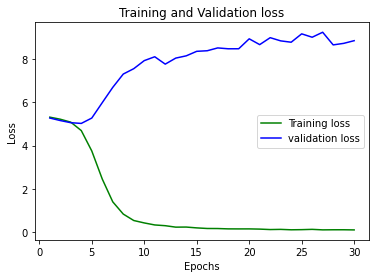

In [ ]:
## Plotting Train and Test loss
epoch=30
loss_train = base_cnn_model.history['loss']
loss_val = base_cnn_model.history['val_loss']
epochs = range(1,epoch+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

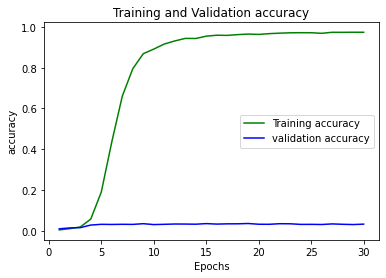

In [ ]:
## Plotting Train and Test accuracy
Acc_train = base_cnn_model.history['accuracy']
Acc_val = base_cnn_model.history['val_accuracy']
epochs = range(1,epoch+1)
plt.plot(epochs, Acc_train, 'g', label='Training accuracy')
plt.plot(epochs, Acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
# Saving the model for future use
cnn_classifier.save('./base_model.h5')
cnn_classifier.save_weights('./base_model_weights.h5')

## 2. Milestone 2: [ Score: 60 points]
- Input: Preprocessed output from Milestone-1
- Process:
### Step 1: Fine tune the trained basic CNN models to classify the car. [ 5 points ]

**Tuning CNN model with Image Augmentation**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
batch_size = 32
train_generator = train_datagen.flow(x=X_train,y=y_train_encoded,
                                       batch_size=batch_size, 
                                       seed=52,
                                       shuffle=True)

valid_generator = valid_datagen.flow(x=X_test,y=y_test_encoded,
                                       batch_size=batch_size, 
                                       seed=52)

In [ ]:
cnn_classifier.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_history=cnn_classifier.fit(train_generator,
                    validation_data = valid_generator,
                    epochs=30,
                    verbose=1)

Epoch 1/30
255/255 [==============================] - 8s 27ms/step - loss: 289.3972 - accuracy: 0.0050 - val_loss: 5.2843 - val_accuracy: 0.0052
Epoch 2/30
255/255 [==============================] - 7s 27ms/step - loss: 5.2911 - accuracy: 0.0044 - val_loss: 5.2793 - val_accuracy: 0.0052
Epoch 3/30
255/255 [==============================] - 7s 28ms/step - loss: 5.2866 - accuracy: 0.0052 - val_loss: 5.2783 - val_accuracy: 0.0052
Epoch 4/30
255/255 [==============================] - 7s 27ms/step - loss: 5.2845 - accuracy: 0.0041 - val_loss: 5.2780 - val_accuracy: 0.0052
Epoch 5/30
255/255 [==============================] - 7s 27ms/step - loss: 5.2806 - accuracy: 0.0045 - val_loss: 5.2777 - val_accuracy: 0.0052
Epoch 6/30
255/255 [==============================] - 7s 27ms/step - loss: 5.2798 - accuracy: 0.0045 - val_loss: 5.2774 - val_accuracy: 0.0052
Epoch 7/30
255/255 [==============================] - 7s 27ms/step - loss: 5.2795 - accuracy: 0.0048 - val_loss: 5.2772 - val_accuracy: 0.00

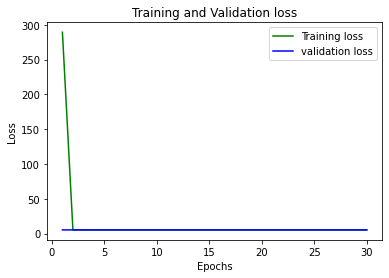

In [ ]:
## Plotting Train and Test loss
epoch=30
loss_train = cnn_history.history['loss']
loss_val = cnn_history.history['val_loss']
epochs = range(1,epoch+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

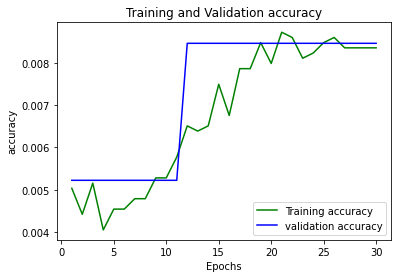

In [ ]:
## Plotting Train and Test accuracy
Acc_train = cnn_history.history['accuracy']
Acc_val = cnn_history.history['val_accuracy']
epochs = range(1,epoch+1)
plt.plot(epochs, Acc_train, 'g', label='Training accuracy')
plt.plot(epochs, Acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

From the above graphs, it is evident that CNN model with image augmentation did not give good predictions either. Even the predictions in train set is not good. 


**Let us try transfer learning using few famous architectures**

**VGG19 model for classifying the car models**

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min")
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [ ]:
vgg_base_model = VGG19(input_shape = (128, 128, 3),
                   weights='imagenet',
                   include_top=False) 

x = vgg_base_model.output
x = GlobalAveragePooling2D()(x)       # Optional
x = Dense(1024, activation='relu')(x) # dense layer 1
x = Dropout(0.2)(x)                   # dropout
x = Dense(512, activation='relu')(x)  # dense layer 2
x = Dropout(0.2)(x)                   # dropout
x = Dense(256, activation='relu')(x)  # dense layer 3
preds = Dense(196, activation='softmax')(x) # final layer with softmax activation

model_vgg19 = Model(inputs=vgg_base_model.input,
                    outputs=preds)

# set the first 20 layers of the network to be non-trainable
for layer in model_vgg19.layers[:20]:
    layer.trainable=False
for layer in model_vgg19.layers[20:]:
    layer.trainable=True

# Compile the model
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001, amsgrad=False)
model_vgg19.compile(optimizer=opt,
                    loss='categorical_crossentropy',
                    metrics=['categorical_accuracy'])

model_vgg19.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
vgg19_model = model_vgg19.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded),callbacks=[reduce_lr, stop], epochs=100, verbose=1)

Epoch 1/100
255/255 [==============================] - 37s 136ms/step - loss: 5.2812 - categorical_accuracy: 0.0049 - val_loss: 5.2334 - val_categorical_accuracy: 0.0146 - lr: 0.0010
Epoch 2/100
255/255 [==============================] - 32s 126ms/step - loss: 4.9939 - categorical_accuracy: 0.0205 - val_loss: 4.6969 - val_categorical_accuracy: 0.0377 - lr: 0.0010
Epoch 3/100
255/255 [==============================] - 32s 124ms/step - loss: 4.4713 - categorical_accuracy: 0.0456 - val_loss: 4.3350 - val_categorical_accuracy: 0.0603 - lr: 0.0010
Epoch 4/100
255/255 [==============================] - 32s 125ms/step - loss: 4.0990 - categorical_accuracy: 0.0815 - val_loss: 4.1141 - val_categorical_accuracy: 0.0842 - lr: 0.0010
Epoch 5/100
255/255 [==============================] - 32s 126ms/step - loss: 3.7650 - categorical_accuracy: 0.1138 - val_loss: 3.9846 - val_categorical_accuracy: 0.0995 - lr: 0.0010
Epoch 6/100
255/255 [==============================] - 32s 125ms/step - loss: 3.4509 

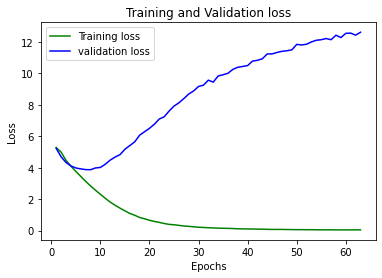

In [ ]:
## Plotting Train and Test loss
epoch=63
loss_train = vgg19_model.history['loss']
loss_val = vgg19_model.history['val_loss']
epochs = range(1,epoch+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

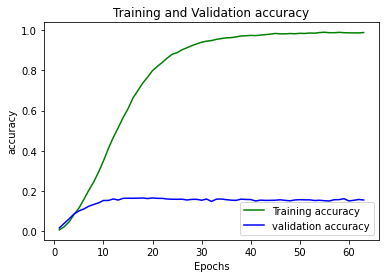

In [ ]:
## Plotting Train and Test accuracy
Acc_train = vgg19_model.history['categorical_accuracy']
Acc_val = vgg19_model.history['val_categorical_accuracy']
epochs = range(1,epoch+1)
plt.plot(epochs, Acc_train, 'g', label='Training accuracy')
plt.plot(epochs, Acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

VGG19 model has given better results compared to basic CNN model. The model has given 98.87% accuracy in train set and 15.41% in test set.

**ResNet50 model for classifying the car models**

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [ ]:
resnet_base_model = ResNet50(input_shape=(128, 128, 3),
                      weights='imagenet',
                      include_top=False)

x = resnet_base_model.output
x = GlobalAveragePooling2D()(x)       # Optional
x = Dense(1024, activation='relu')(x) # Dense layer 1
x = Dropout(0.2)(x)                   # dropout
x = Dense(512, activation='relu')(x)  # Dense layer 2
x = Dropout(0.2)(x)                   # Dropout
x = Dense(256, activation='relu')(x)  # Dense layer 3
preds = Dense(196, activation='softmax')(x) #final layer with softmax activation

model_resnet50 = Model(inputs=resnet_base_model.input,
                       outputs=preds)

# set the first 20 layers of the network to be non-trainable
for layer in model_resnet50.layers[:20]:
    layer.trainable=False
for layer in model_resnet50.layers[20:]:
    layer.trainable=True

# Compile the model
model_resnet50.compile(optimizer='sgd',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

model_resnet50.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']       

In [ ]:
resnet50 = model_resnet50.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded),callbacks=[reduce_lr, stop], epochs=100, verbose=1)

Epoch 1/100
255/255 [==============================] - 44s 153ms/step - loss: 5.3102 - accuracy: 0.0055 - val_loss: 5.2865 - val_accuracy: 0.0047 - lr: 0.0100
Epoch 2/100
255/255 [==============================] - 37s 144ms/step - loss: 5.2810 - accuracy: 0.0060 - val_loss: 5.2772 - val_accuracy: 0.0060 - lr: 0.0100
Epoch 3/100
255/255 [==============================] - 37s 145ms/step - loss: 5.2707 - accuracy: 0.0074 - val_loss: 5.2710 - val_accuracy: 0.0083 - lr: 0.0100
Epoch 4/100
255/255 [==============================] - 37s 145ms/step - loss: 5.2510 - accuracy: 0.0076 - val_loss: 5.2541 - val_accuracy: 0.0112 - lr: 0.0100
Epoch 5/100
255/255 [==============================] - 37s 145ms/step - loss: 5.2171 - accuracy: 0.0144 - val_loss: 5.2174 - val_accuracy: 0.0167 - lr: 0.0100
Epoch 6/100
255/255 [==============================] - 37s 145ms/step - loss: 5.1423 - accuracy: 0.0205 - val_loss: 5.1301 - val_accuracy: 0.0224 - lr: 0.0100
Epoch 7/100
255/255 [=========================

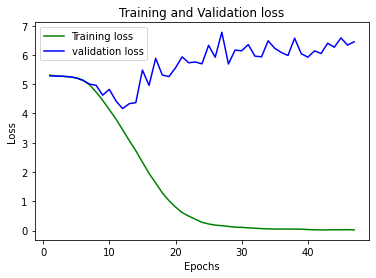

In [ ]:
## Plotting Train and Test loss
epoch=47
loss_train = resnet50.history['loss']
loss_val = resnet50.history['val_loss']
epochs = range(1,epoch+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

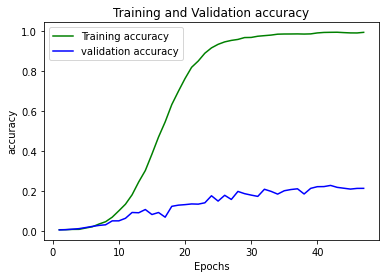

In [ ]:
## Plotting Train and Test accuracy
Acc_train = resnet50.history['accuracy']
Acc_val = resnet50.history['val_accuracy']
epochs = range(1,epoch+1)
plt.plot(epochs, Acc_train, 'g', label='Training accuracy')
plt.plot(epochs, Acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

**MobileNet model for classifying the car models**

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

mobilenet_base_model = MobileNet(input_shape=X_train[0].shape,
                       weights='imagenet',
                       include_top=False) 

x = mobilenet_base_model.output
x = GlobalAveragePooling2D()(x)       # Optional
x = Dense(1024,activation='relu')(x)  # Dense layer 1
x = Dropout(0.2)(x)                   # Dropout
x = Dense(512,activation='relu')(x)   # Dense layer 2
x = Dropout(0.2)(x)                   # Dropout
x = Dense(256,activation='relu')(x)   # Dense layer 3
preds = Dense(196,activation='softmax')(x) # final layer with softmax activation

model_mobilenet = Model(inputs=mobilenet_base_model.input,
                        outputs=preds)

# set the first 20 layers of the network to be non-trainable
for layer in model_mobilenet.layers[:20]:
    layer.trainable=False
for layer in model_mobilenet.layers[20:]:
    layer.trainable=True

# Compile the model
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001, amsgrad=False)
model_mobilenet.compile(optimizer=opt,
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

model_mobilenet.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                                    

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 conv_pw_7_relu (ReLU)       (None, 8, 8, 512)         0         
                                                                 
 conv_dw_8 (DepthwiseConv2D)  (None, 8, 8, 512)        4608      
                                                                 
 conv_dw_8_bn (BatchNormaliz  (None, 8, 8, 512)        2048      
 ation)                                                          
                                                                 
 conv_dw_8_relu (ReLU)       (None, 8, 8, 512)         0         
                                                                 
 conv_pw_8 (Conv2D)          (None, 8, 8, 512)         262144    
                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 8, 8, 512)        2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 8, 8, 512)         0         
          

In [ ]:
mobilenet = model_mobilenet.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), callbacks=[reduce_lr, stop], epochs=200, verbose=1)

Epoch 1/200
255/255 [==============================] - 16s 51ms/step - loss: 5.0593 - accuracy: 0.0172 - val_loss: 5.0251 - val_accuracy: 0.0363 - lr: 0.0010
Epoch 2/200
255/255 [==============================] - 11s 44ms/step - loss: 4.1041 - accuracy: 0.0657 - val_loss: 3.9427 - val_accuracy: 0.0874 - lr: 0.0010
Epoch 3/200
255/255 [==============================] - 11s 44ms/step - loss: 3.3450 - accuracy: 0.1465 - val_loss: 3.3056 - val_accuracy: 0.1701 - lr: 0.0010
Epoch 4/200
255/255 [==============================] - 11s 44ms/step - loss: 2.6825 - accuracy: 0.2514 - val_loss: 2.8594 - val_accuracy: 0.2438 - lr: 0.0010
Epoch 5/200
255/255 [==============================] - 11s 44ms/step - loss: 2.1371 - accuracy: 0.3681 - val_loss: 2.9775 - val_accuracy: 0.2470 - lr: 0.0010
Epoch 6/200
255/255 [==============================] - 11s 44ms/step - loss: 1.6491 - accuracy: 0.4790 - val_loss: 2.6554 - val_accuracy: 0.3253 - lr: 0.0010
Epoch 7/200
255/255 [==============================]

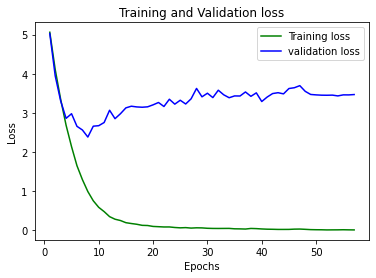

In [ ]:
## Plotting Train and Test loss
epoch=57
loss_train = mobilenet.history['loss']
loss_val = mobilenet.history['val_loss']
epochs = range(1,epoch+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

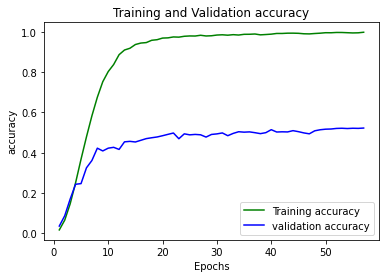

In [ ]:
## Plotting Train and Test accuracy
Acc_train = mobilenet.history['accuracy']
Acc_val = mobilenet.history['val_accuracy']
epochs = range(1,epoch+1)
plt.plot(epochs, Acc_train, 'g', label='Training accuracy')
plt.plot(epochs, Acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

Of all the models tried above, MobileNet model has given best results. The model has produced 99.82% accuracy in train set and 52.27% accuracy in test set. 

In [ ]:
from matplotlib import pyplot as plt
def predict_images(images_list,n):
    rand = np.random.randint(0, len(images_list), n) # Generating n random numbers from total number of images
    print("Showing images with index in : {}".format(rand))
    plt.figure(figsize=(10, 10))
    for cnt,j in enumerate(rand):
        plt.subplot(n, 2, (cnt*2)+1)
        plt.title("Actual : {}".format(images_list[j]['car_name']))
        plt.imshow(images_list[j]['car_orig_image'])
        plt.subplot(n, 2, (cnt*2)+2)
        plt.imshow(images_list[j]['car_orig_image'])

        temp_image=images_list[j]['car_orig_image'].copy()
        temp_image_upd = (temp_image / 255.).astype(np.float32)
        temp_image_upd = cv2.resize(temp_image_upd, dsize = (128,128))

        temp_image_upd_arr = np.empty((1,128,128,3))
        temp_image_upd_arr[0]=temp_image_upd

        # predict using the trained model 
        predicted_class = model_mobilenet.predict(temp_image_upd_arr) 

        # Index of the class with maximum probability
        predicted_index = np.argmax(predicted_class[0])  
        predict_class=cars_dict[predicted_index+1]

        # display actual image with predicted name
        plt.title("Predicted: {}".format(predict_class))


Showing images with index in : [8116 4088 7414]
1/1 [==============================] - 0s 18ms/step


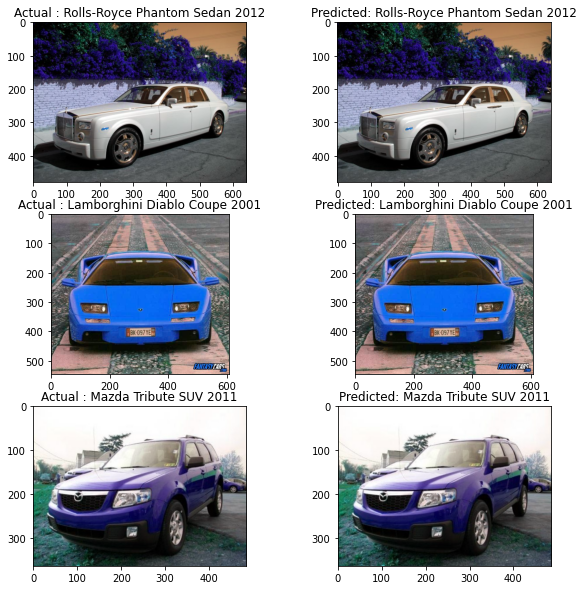

In [ ]:
predict_images(train_images_upd,3)

**As shown above, the MobileNet model has correctly predicted all the 3 random test samples. The classification model MobileNet can be saved for future use.**

In [ ]:
# Saving the model for future use
model_mobilenet.save('/content/drive/MyDrive/Project Files/model_mobilenet_classfier.h5')
model_mobilenet.save_weights('/content/drive/MyDrive/Project Files/model_mobilenet_classifier_weights.h5')

 ### Step 2: Design, train and test RCNN & its hybrids based object detection models to impose the bounding box or mask over the area of interest. [ 10 points ] 

**Object Detection models**

**Train and Test dataset preparation**

In [ ]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
ALPHA = 1

In [ ]:
from matplotlib import pyplot as plt
def show_images(images_list,n):
    rand = np.random.randint(0, len(images_list), n) # Generating n random numbers from total number of images
    print("Showing images with index in : {}".format(rand))
    plt.figure(figsize=(10, 20))
    for cnt,j in enumerate(rand):
        plt.subplot(n, 2, (cnt*2)+1)
        plt.title(images_list[j]['car_name'])
        img_orig=images_list[j]['car_orig_image']
        img_upd = cv2.resize(images_list[j]['car_orig_image'], dsize = (224,224))
        plt.imshow(img_upd)
        #plt.imshow(images_list[j]['car_orig_image'])
        plt.subplot(n, 2, (cnt*2)+2)
        #temp_image=images_list[j]['car_orig_image'].copy()
        temp_image=img_upd.copy()
        print(temp_image.shape)
        (img_orig_h, img_orig_w, c)=img_orig.shape
        gray = cv2.cvtColor(temp_image, cv2.COLOR_BGR2GRAY)
        (x1, y1, x2, y2)=images_list[j]['bounding_box']
        print((x1, y1, x2, y2))
        x1_=int((x1/img_orig_w)*224)
        x2_=int((x2/img_orig_w)*224)
        y1_=int((y1/img_orig_h)*224)
        y2_=int((y2/img_orig_h)*224)
        print((x1_, y1_, x2_, y2_))
        cv2.rectangle(temp_image, (x1_,y1_), (x2_,y2_), (255,0,0), 4)  
        plt.title(images_list[j]['car_name'])
        plt.imshow(temp_image)

In [ ]:
X = np.zeros((int(1000), IMAGE_HEIGHT, IMAGE_WIDTH , 3))
masks = np.zeros((int(1000), IMAGE_HEIGHT, IMAGE_WIDTH))

for index in range(0,1000):
  img_orig = train_images_upd[index]['car_orig_image']
  (img_orig_h, img_orig_w, c)=img_orig.shape
  image_upd = cv2.resize(img_orig, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
  X[index] = preprocess_input(np.array(image_upd, dtype=np.float32))
  # for i in train_dataset[index][1]:

  (x1, y1, x2, y2)=train_images_upd[index]['bounding_box']

  x1_=int((x1/img_orig_w)*224)
  x2_=int((x2/img_orig_w)*224)
  y1_=int((y1/img_orig_h)*224)
  y2_=int((y2/img_orig_h)*224)
  # set all pixels within the mask co-ordinates to 1.
  masks[index][y1_:y2_, x1_:x2_] = 1

In [ ]:
X = np.array(X)

In [ ]:
print("The shape of the features is {}".format(X.shape))
print("The shape of mask is {}".format(masks.shape))

The shape of the features is (1000, 224, 224, 3)
The shape of mask is (1000, 224, 224)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, masks, test_size=0.2)
print("The shape of X_train is", X_train.shape)
print("The shape of y_train is", y_train.shape)
print("")
print("The shape of X_test is", X_test.shape)
print("The shape of y_test is", y_test.shape)

The shape of X_train is (800, 224, 224, 3)
The shape of y_train is (800, 224, 224)

The shape of X_test is (200, 224, 224, 3)
The shape of y_test is (200, 224, 224)


The random number is 47


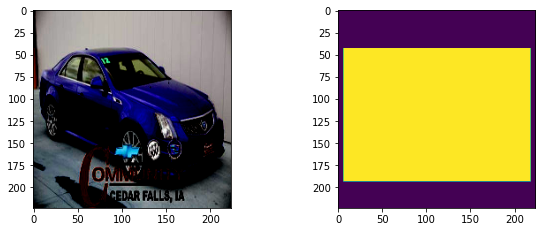

In [ ]:
import random
fig = plt.figure(figsize=(10,8))
n = random.randint(0, X_train.shape[0])
print("The random number is", n)
ax1 = fig.add_subplot(2, 2, 1)
ax1.imshow(X_train[n])
ax2 = fig.add_subplot(2, 2, 2)
ax2.imshow(y_train[n])

**MobileNet model for car detection with mask**

In [ ]:
img_height=224
img_width=224
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D
def create_cardetect_model(trainable=True):
    cv_model = MobileNet(input_shape=(img_height, img_width, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in cv_model.layers:
        layer.trainable = trainable
  
    block0 = cv_model.get_layer("conv_pw_1_relu").output
    block1 = cv_model.get_layer("conv_pw_3_relu").output
    block2 = cv_model.get_layer("conv_pw_5_relu").output
    block3 = cv_model.get_layer("conv_pw_11_relu").output
    block4 = cv_model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block2])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block1])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block0])
    print(x.shape)
    x = UpSampling2D()(x)
    print(x.shape)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((img_height, img_width))(x)
    print(x.shape)

    return Model(inputs=cv_model.input, outputs=x)

In [ ]:
cardetect_model = create_cardetect_model(False)

(None, 14, 14, 1536)
(None, 28, 28, 1792)
(None, 56, 56, 1920)
(None, 112, 112, 1984)
(None, 224, 224, 1984)
(None, 224, 224)


In [ ]:
cardetect_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                           

In [ ]:
from tensorflow import reduce_sum
from tensorflow.keras.backend import epsilon

# Defining dice coefficient 
def dice_coefficient(y_true, y_pred):
    numerator = 2 * reduce_sum(y_true * y_pred)
    denominator = reduce_sum(y_true + y_pred)
    return numerator / (denominator + epsilon())

In [ ]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log

# Defining loss function
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [ ]:
cardetect_model.compile(loss=loss, optimizer='adam', metrics=[dice_coefficient])

In [ ]:
cardetect_model_fit=cardetect_model.fit(X_train, y_train, epochs=40, batch_size=1, callbacks=[reduce_lr, stop],validation_data=(X_test, y_test))

Epoch 1/40
800/800 [==============================] - 29s 34ms/step - loss: 0.5197 - dice_coefficient: 0.8397 - val_loss: 0.4166 - val_dice_coefficient: 0.8620 - lr: 0.0010
Epoch 2/40
800/800 [==============================] - 27s 33ms/step - loss: 0.4032 - dice_coefficient: 0.8710 - val_loss: 0.3850 - val_dice_coefficient: 0.8706 - lr: 0.0010
Epoch 3/40
800/800 [==============================] - 26s 33ms/step - loss: 0.3772 - dice_coefficient: 0.8790 - val_loss: 0.4252 - val_dice_coefficient: 0.8673 - lr: 0.0010
Epoch 4/40
800/800 [==============================] - 26s 33ms/step - loss: 0.3673 - dice_coefficient: 0.8834 - val_loss: 0.3710 - val_dice_coefficient: 0.8816 - lr: 0.0010
Epoch 5/40
800/800 [==============================] - 26s 33ms/step - loss: 0.3625 - dice_coefficient: 0.8853 - val_loss: 0.3834 - val_dice_coefficient: 0.8777 - lr: 0.0010
Epoch 6/40
800/800 [==============================] - 26s 33ms/step - loss: 0.3541 - dice_coefficient: 0.8882 - val_loss: 0.4237 - val_

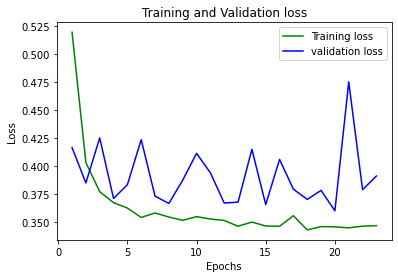

In [ ]:
## Plotting Train and Test loss
epoch=23
loss_train = cardetect_model_fit.history['loss']
loss_val = cardetect_model_fit.history['val_loss']
epochs = range(1,epoch+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

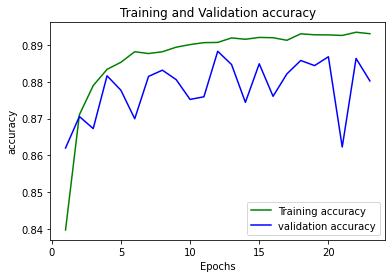

In [ ]:
## Plotting Train and Test accuracy
Acc_train = cardetect_model_fit.history['dice_coefficient']
Acc_val = cardetect_model_fit.history['val_dice_coefficient']
epochs = range(1,epoch+1)
plt.plot(epochs, Acc_train, 'g', label='Training accuracy')
plt.plot(epochs, Acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

MobileNet has given good accuracies in both train set and test set. In train set, the model has given 89.31% dice_coefficient and in test set 88.02% dice_coefficient. Since the results are very close in train and test set, the model has consistently performed well and can be saved for future use.

In [ ]:
# Saving the model for future use
cardetect_model.save('/content/drive/MyDrive/Project Files/model_mobilenet_cardetect.h5')
cardetect_model.save_weights('/content/drive/MyDrive/Project Files/model_mobilenet_cardetect_weights.h5')

**Showing sample images and the predicted mask area.**

In [ ]:
def mobilenet_predict_show(n):
    plt.figure(figsize=(10, 20))
    for j in range(n):
        plt.subplot(n, 2, (j*2)+1)
        plt.title('Actual Image')
        plt.imshow(X_test[j])
        plt.subplot(n, 2, (j*2)+2)
        plt.imshow(y_test[j])
        plt.title("Predicted Mask on Image")

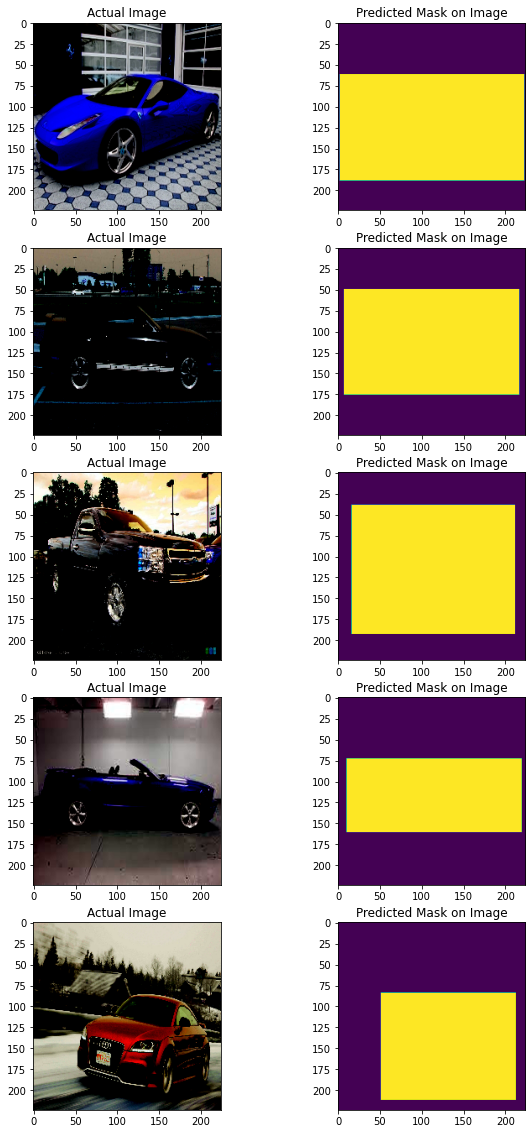

In [ ]:
mobilenet_predict_show(5)

**YOLO model for car detection with bounding box**

In [ ]:
!wget "https://pjreddie.com/media/files/yolov3.weights"

!wget "https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg"

!wget "https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names"

--2023-01-14 18:47:23--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  23.4MB/s    in 11s     

2023-01-14 18:47:35 (21.7 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2023-01-14 18:47:35--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      


In [ ]:
### Load YOLO model with trained weights and coco classes

yolo_net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")

classes = []
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

layer_names = yolo_net.getLayerNames()

#Get output layer names from the YOLO model
output_layers = [layer_names[i -1] for i in yolo_net.getUnconnectedOutLayers()]

print("Number of items loaded in output_layers :{}".format(len(output_layers)))

Number of items loaded in output_layers :3


In [ ]:
import random
def yolo_model_fit(n):
    
    yolo_img_predictions=[]
    rand = random.sample(range(len(train_images_upd)), n)

    for cnt,j in enumerate(rand):
        samp_img=train_images_upd[j]['car_orig_image']
        
        height, width, channels = samp_img.shape
        blob = cv2.dnn.blobFromImage(samp_img, 1 / 255.0, (320, 320),swapRB=True, crop=False)
        yolo_net.setInput(blob)
        outs = yolo_net.forward(output_layers)

    # detcting the objects in image
        class_ids = []
        confidences = []
        boxes = []

        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                
                if confidence > 0.9:
                    
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)

                # Rectangle coordinates
                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)
                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)
        
        indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
        colors = np.random.uniform(0, 255, size=(len(classes), 3))
 
        for i in range(len(boxes)):
            if i in indexes:
                x, y, w, h = boxes[i]
                label = str(classes[class_ids[i]])
                color = colors[class_ids[i]]
                cv2.rectangle(samp_img, (x, y), (x + w, y + h),(255,0,0), 4)
                cv2.putText(samp_img, label, (x, y -5),cv2.FONT_HERSHEY_SIMPLEX,1/2,color, 2)
                yolo_img_predictions.append(samp_img)
    return yolo_img_predictions

In [ ]:
def yolo_predict_show(n):
    yolo_img_predictions=yolo_model_fit(n)

    plt.figure(figsize=(20, 20))
    for i in range(len(yolo_img_predictions)):
        plt.subplot(1, len(yolo_img_predictions), i+1)
        plt.imshow(yolo_img_predictions[i])
        plt.axis('off')
    plt.show()

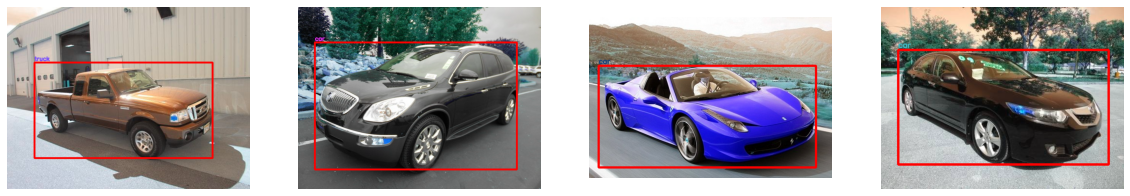

In [ ]:
yolo_predict_show(4)

YOLO3 model has also produced good results. In the above plots, yolo model has correctly detected the cars in the random samples images. 

## Step 3: Pickle the model for future prediction [ 5 Points]

In [ ]:
### Function to save the tuned model as pickle file
import pickle
def save_tuned_model(model_name, file_name):
    pickle.dump(model_name, open(file_name, 'wb'))

In [ ]:
save_tuned_model(model_mobilenet,'/content/drive/MyDrive/Project Files/model_mobilenet_classfier.pkl')

In [ ]:
save_tuned_model(cardetect_model,'/content/drive/MyDrive/Project Files/model_mobilenet_cardetect.pkl')

Models can also be saved as below

In [ ]:
# Saving the model for future use
model_mobilenet.save('/content/drive/MyDrive/Project Files/model_mobilenet_classfier.h5')
model_mobilenet.save_weights('/content/drive/MyDrive/Project Files/model_mobilenet_classifier_weights.h5')

In [ ]:
# Saving the model for future use
cardetect_model.save('/content/drive/MyDrive/Project Files/model_mobilenet_cardetect.h5')
cardetect_model.save_weights('/content/drive/MyDrive/Project Files/model_mobilenet_cardetect_weights.h5')

# Conclusion

Of all the models tried above, MobileNet gave consistent and better predictions for both classification problem and object detection problem. 
Both models has given correct predictions for the random test samples tried. Hence the MobileNet models for both classification and object detection are saved for future use. 

 ## Step 4: Final Report [40 Points]
Final report is created separately as word document. The same will be uploaded to the Solution link.

# THE END